# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams 
This is the code for the paper entitled "**A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams**" accepted in IEEE Internet of Things Magazine.  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 4: Real-time prediction with concept drift adaptation**  
Aims:  
&nbsp; 1): Develop a real-time classifier with concept drift detection  
&nbsp; 2): Plot a figure/gif to show the real-time prediction results that can be updated over time.

## Import libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from river import metrics
from river import stream
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns

## Read the NSL-KDD dataset

In [4]:
df = pd.read_csv("NSL_KDD_binary(train+test).csv")
df1 = pd.read_csv("NSL_KDD_binary_train.csv")
df2 = pd.read_csv("NSL_KDD_binary_test.csv")

### Data sampling
Use the last 10% of training set and the entire test set

In [5]:
df_used = int(len(df1)*0.1) + len(df2)
df0 = df.iloc[-df_used:]

## Train-test split
10% training set, and 90% test set

In [6]:
X = df0.drop(['label'],axis=1)
y = df0['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False, random_state = 0)

## Offline learning: LightGBM

In [7]:
classifier = lgb.LGBMClassifier()
# classifier = joblib.load('Optimized_lightGBM.pkl') 
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,predictions)))

Accuracy: 0.8420969424858507


In [8]:
%matplotlib qt5
#%matplotlib inline

def oasw_real_time(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    plt.ion() #start interactive mode 
    #plt.figure(1, constrained_layout=True)
    plt.figure(1,figsize=(12,7.5))
    sns.set_style("darkgrid")
    
    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)
    
    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1)) 
        metric2 = metric2.update(yi, y_pred2)
        
        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:]) 
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        
#     if i == (10000):
        plt.clf() 
        plt.plot(t,m,'-b',label='RMSE with drift')
        plt.plot(t,m2,'pink',label='RMSE without drift')
        #plt.plot(t,yp,'-g',label='True values')
        #plt.plot(t,yt,'-r',label='Predicted values')
        plt.legend(loc='upper left')
        plt.title('NSL-KDD Dataset Online Learning Results', fontsize=15,pad =10)
        plt.suptitle('NSL-KDD Dataset Results'+'\nAvg Test Accuracy of Adaptive LightGBM: '+str(round(metric.get()*100, 2))+'\nAvg Test Accuracy of Offline LightGBM: '
                     +str(round(metric2.get()*100, 2))+'\nDrift detected at timestamps: '+str(dr[1:]), fontsize=10,verticalalignment='baseline')
        plt.xlabel('Number of samples')
        plt.ylabel('Accuracy (%)')

        plt.draw()

        plt.pause(0.000000001)

        i=i+1

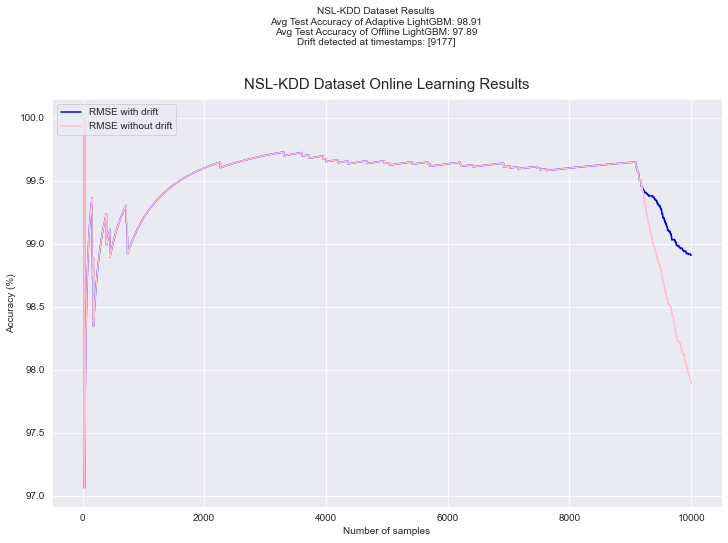

In [11]:
oasw_real_time(a = 0.978, b = 0.931, win1 = 611, win2 = 4320)